In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import gridspec
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, ParameterGrid
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

In [2]:
MNIST_train = datasets.MNIST(
    "./Datasets", train=True, download=True, transform=transforms.ToTensor()
)
MNIST_test = datasets.MNIST(
    "./Datasets", train=False, download=True, transform=transforms.ToTensor()
)

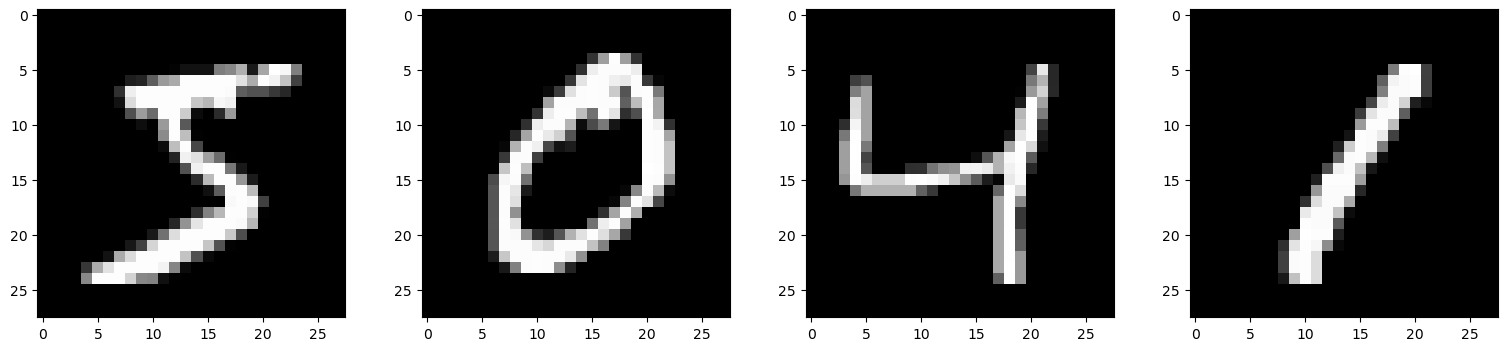

In [3]:
fig, gs = plt.figure(figsize=(19, 4)), gridspec.GridSpec(1, 4)
ax = []
for i in range(4):
    ax.append(fig.add_subplot(gs[i]))
    ax[i].imshow(np.array(MNIST_train[i][0][0]), "gray")

In [4]:
class Perceptron(torch.nn.Module):
    def __init__(
        self,
        input_dim=784,
        num_layers=0,
        hidden_dim=64,
        output_dim=10,
        p=0.0,
        device="cpu",
    ):
        super(Perceptron, self).__init__()
        self.layers = torch.nn.Sequential()

        prev_size = input_dim
        for i in range(num_layers):
            self.layers.add_module(f"layer{i}", torch.nn.Linear(prev_size, hidden_dim))
            self.layers.add_module(f"relu{i}", torch.nn.ReLU())
            self.layers.add_module(f"dropout{i}", torch.nn.Dropout(p=p))
            prev_size = hidden_dim
        self.layers.add_module("classifier", torch.nn.Linear(prev_size, output_dim))
        self.to(device)

    def forward(self, input):
        return self.layers(input)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cpu')

In [7]:
model = Perceptron(num_layers=2)

In [8]:
model

Perceptron(
  (layers): Sequential(
    (layer0): Linear(in_features=784, out_features=64, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.0, inplace=False)
    (layer1): Linear(in_features=64, out_features=64, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.0, inplace=False)
    (classifier): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [9]:
def testing(model, dataset):
    generator = torch.utils.data.DataLoader(dataset, batch_size=64)
    pred = []
    real = []
    for x, y in tqdm(generator, leave=False):
        x = x.view([-1, 784]).to(device)
        y = y.to(device)
        pred.extend(torch.argmax(model(x), dim=-1).cpu().numpy().tolist())
        real.extend(y.cpu().numpy().tolist())
    return np.mean(np.array(real) == np.array(pred)), classification_report(real, pred)

In [10]:
def trainer(model, dataset, loss_fn, opt, epochs):
    for epoch in tqdm(range(epochs), leave=False):
        generator = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
        for x, y in tqdm(generator, leave=False):
            opt.zero_grad()
            x = x.view([-1, 784]).to(device)
            y = y.to(device)
            output = model(x)
            loss = loss_fn(output, y)
            loss.backward()
            opt.step()

In [11]:
_ = model.train()
trainer(
    model=model,
    dataset=MNIST_train,
    loss_fn=torch.nn.CrossEntropyLoss(),
    opt=torch.optim.Adam(model.parameters(), lr=0.001),
    epochs=1,
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

In [12]:
_ = model.eval()
acc, report = testing(model, MNIST_test)

  0%|          | 0/157 [00:00<?, ?it/s]

In [13]:
print(report)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.91      0.96      0.93      1032
           3       0.89      0.95      0.92      1010
           4       0.97      0.90      0.93       982
           5       0.94      0.89      0.91       892
           6       0.97      0.94      0.96       958
           7       0.97      0.92      0.94      1028
           8       0.89      0.91      0.90       974
           9       0.91      0.92      0.91      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



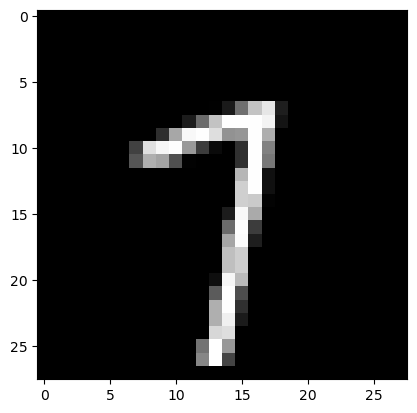

In [14]:
plt.imshow(np.array(MNIST_train[42][0][0]), "gray")

In [15]:
model(MNIST_train[42][0].view([-1, 784]))

tensor([[-3.8601, -2.3749, -1.2736, -0.1983, -3.6438, -1.5914, -7.1710,  4.5651,
         -0.5148,  1.8222]], grad_fn=<AddmmBackward0>)

In [16]:
cross_val = KFold(3)
number_of_batch = cross_val.get_n_splits(MNIST_train)

grid = ParameterGrid(
    {"num_layers": [0, 2], "hidden_dim": [8, 64], "p": [0.3, 0.7], "lr": [0.001]}
)

X_train = MNIST_train.transform(MNIST_train.data.numpy()).transpose(0, 1)
Y_train = MNIST_train.targets.data

In [17]:
scores = dict()
for item in tqdm(grid):
    list_of_scores = []
    for train_index, test_index in tqdm(
        cross_val.split(X_train), total=number_of_batch, leave=False
    ):
        x_train_fold = X_train[train_index]
        x_test_fold = X_train[test_index]
        y_train_fold = Y_train[train_index]
        y_test_fold = Y_train[test_index]
        traindata = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
        testdata = torch.utils.data.TensorDataset(x_test_fold, y_test_fold)

        model = Perceptron(
            num_layers=item["num_layers"],
            p=item["p"],
            hidden_dim=item["hidden_dim"],
            device=device,
        )
        _ = model.train()
        trainer(
            model=model,
            dataset=traindata,
            loss_fn=torch.nn.CrossEntropyLoss(),
            opt=torch.optim.Adam(model.parameters(), lr=item["lr"]),
            epochs=1,
        )
        _ = model.eval()
        acc, report = testing(model, testdata)
        list_of_scores.append(acc)
    scores[str(item)] = [np.mean(list_of_scores)]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

D:\Installed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Installed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Installed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

D:\Installed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Installed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Installed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

D:\Installed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Installed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Installed\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

In [18]:
scores

{"{'hidden_dim': 8, 'lr': 0.001, 'num_layers': 0, 'p': 0.3}": [0.8955000000000001],
 "{'hidden_dim': 8, 'lr': 0.001, 'num_layers': 0, 'p': 0.7}": [0.8954],
 "{'hidden_dim': 8, 'lr': 0.001, 'num_layers': 2, 'p': 0.3}": [0.7479666666666667],
 "{'hidden_dim': 8, 'lr': 0.001, 'num_layers': 2, 'p': 0.7}": [0.4708333333333334],
 "{'hidden_dim': 64, 'lr': 0.001, 'num_layers': 0, 'p': 0.3}": [0.8950999999999999],
 "{'hidden_dim': 64, 'lr': 0.001, 'num_layers': 0, 'p': 0.7}": [0.8950999999999999],
 "{'hidden_dim': 64, 'lr': 0.001, 'num_layers': 2, 'p': 0.3}": [0.9196666666666666],
 "{'hidden_dim': 64, 'lr': 0.001, 'num_layers': 2, 'p': 0.7}": [0.8746166666666667]}